## 一、爬取数据

In [22]:
import urllib3
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV  
from sklearn.metrics import classification_report, roc_auc_score, auc, roc_curve, make_scorer, precision_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


pd.set_option('display.max_columns', 50)

In [2]:
def getPage(herf):
    headers = {
        'user-agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.0.0 Safari/537.36'
    }
    http = urllib3.PoolManager()
    req = http.request(
        method = 'GET'
        ,url = herf
        ,headers = headers
    )
#     print(req.data)
    return req.data

def getPageNum(url):
    num = 0
    page = getPage(url)
    soup = BeautifulSoup(page)
    strong = soup.find('td', colspan='7')
    if strong:
        result = strong.get_text().split(' ')
        list_num = re.findall('[0-9]{1}', result[1])
        for i in range(len(list_num)):
            num = num*10 + int(list_num[i])
        return num
    else:
        return 0
            
def getText(url):
    for list_num in range(getPageNum(url), 0, -1):
        print(list_num)
        herf = 'http://kaijiang.zhcw.com/zhcw/html/ssq/list_' + str(list_num) + '.html'
        page = BeautifulSoup(getPage(herf))
#         print(page)
        em_list = page.find_all('em')
        div_list = page.find_all('td', {'align':'center'})
        
        text_list = []
        for i in range(9):
            text_list.append([])
        
        with open ('num.txt', 'a') as f:
            for d, div in enumerate(div_list):
                if d%5 == 0 or d%5 == 1:
                    text_list[d%5].append(div.get_text())
            text_list[0] = text_list[0][:-1]
            for e, em in enumerate(em_list):
                text_list[e%7+2].append(em.get_text())
#             print(text_list)
            for i in range(9):
                text_list[i].reverse()
            pd.DataFrame(text_list).T.to_csv('num.txt', sep = ',', mode = 'a', index = None, header = 0)

In [3]:
url = 'http://kaijiang.zhcw.com/zhcw/html/ssq/list_1.html'
getText(url)

158
157
156
155
154
153
152
151
150
149
148
147
146
145
144
143
142
141
140
139
138
137
136
135
134
133
132
131
130
129
128
127
126
125
124
123
122
121
120
119
118
117
116
115
114
113
112
111
110
109
108
107
106
105
104
103
102
101
100
99
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1


## 二、预测

### 2.1 路线一：根据每个数的出现频率，出现间隔等等，预测每个数在下次是否会出现

In [2]:
data_o = pd.read_table('num.txt', sep = ',', header = None, names = ['date', 'phase', 'red1', 'red2', 'red3', 'red4', 'red5', 'red6', 'blue'], parse_dates = ['date'])
data_o.head()

,date,phase,red1,red2,red3,red4,red5,red6,blue
0,2003-02-23,2003001,10,11,12,13,26,28,11
1,2003-02-27,2003002,4,9,19,20,21,26,12
2,2003-03-02,2003003,1,7,10,23,28,32,16
3,2003-03-06,2003004,4,6,7,10,13,25,3
4,2003-03-09,2003005,4,6,15,17,30,31,16


In [3]:
# 记录各数字出现的期数

appear_dict = {}
for i in range(33):
    appear_dict[i+1] = []
# appear_dict

for phase in range(data_o.shape[0]):
    tmp_list = data_o.iloc[phase].tolist()[2:-1]
    for num in range(33):
        if num+1 in tmp_list:
            appear_dict[num+1].append(1)
        else:
            appear_dict[num+1].append(0)
pd.DataFrame(appear_dict).head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0
3,0,0,0,1,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0


In [4]:
# 从第一个数据开始，记录频率，隔了多久，出现次数，是否出现等
# 生成特征函数
def gene_feature(num_list):
    phase_num = 1  # 当前期数
    appear_gep = 0   # 已经有几期没出现
    features = []
    num_100 = 0
    per_100 = 0

    for i in num_list:
        num_total = np.sum(num_list[0:phase_num])  # 总共出现次数
        per_total = np.sum(num_list[0:phase_num]) / phase_num  # 总共出现比例
        if phase_num > 100:
            num_100 = np.sum(num_list[phase_num-100:phase_num])  # 近100期出现次数
            per_100 = np.sum(num_list[phase_num-100:phase_num]) / 100  # 近100期共出现比例
        if i == 0:
            appear_gep += 1
        else:
            appear_gep = 0
        # 离上次出现期数、总共出现次数、总共出现比例、近100期出现次数、近100期出现比例
        features.append([appear_gep, num_total, per_total, num_100, per_100, num_list[min(phase_num, len(num_list)-1)]])
        phase_num += 1
    return features


In [5]:
# 看看输出情况

features_1 = gene_feature(appear_dict[1])

with pd.ExcelWriter('tmp.xlsx', engine='openpyxl') as writer:  
    pd.DataFrame(appear_dict[1]).to_excel(writer, sheet_name='Sheet1', index=False)
    pd.DataFrame(features_1).to_excel(writer, sheet_name='Sheet2', index=False)


In [25]:
# 先建模试试
X = pd.DataFrame(features_1).iloc[:, :-1]
y = pd.DataFrame(features_1).iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=66)

dtrain = xgb.DMatrix(X_train, label=y_train)  
dtest = xgb.DMatrix(X_test, label=y_test)  

param_grid = {  
    'max_depth': [3, 5, 7],  
    'n_estimators': [100, 200, 300],  
    'learning_rate': [0.05, 0.1, 0.15],  
    'subsample': [0.6, 0.8, 1.0],  
    'colsample_bytree': [0.6, 0.8, 1.0]  
}


<Axes: >

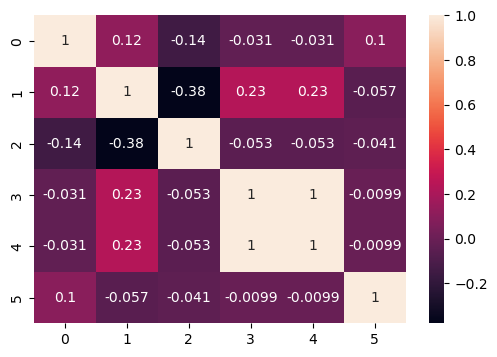

In [15]:
plt.subplots(figsize=(6,4))
correlation_mat = pd.DataFrame(features_1).corr()  # 求相关系数矩阵
sns.heatmap(correlation_mat, annot=True)  # 热度图； annot=True表示添加数值到图中

In [26]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False)  # 在较新版本的xgboost中，需要设置use_label_encoder=False 
  
# 定义评估函数为精确率  
precision_scorer = make_scorer(precision_score, average='binary' if len(set(y)) == 2 else 'weighted')

grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring=precision_scorer, verbose=1)

# 在DMatrix上执行网格搜索可能会遇到问题，因此通常直接在numpy数组上训练  
grid_search.fit(X_train, y_train)  
  
# 获取最佳参数  
best_params = grid_search.best_params_  
print("Best parameters:", best_params)  
  
# 使用最佳参数训练模型  
xgb_best = xgb.XGBClassifier(**best_params, use_label_encoder=False)  
xgb_best.fit(X_train, y_train)  
  
# 预测测试集  
y_pred = xgb_best.predict(X_test)  
y_prob = xgb_best.predict_proba(X_test)[:, 1]  # 获取正类的概率  
  
# 输出分类报告  
print(classification_report(y_test, y_pred)) 

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


d:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predic

Best parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
              precision    recall  f1-score   support

           0       0.82      0.98      0.89       250
           1       0.14      0.02      0.03        53

    accuracy                           0.81       303
   macro avg       0.48      0.50      0.46       303
weighted avg       0.71      0.81      0.74       303



AUC: 58.12%


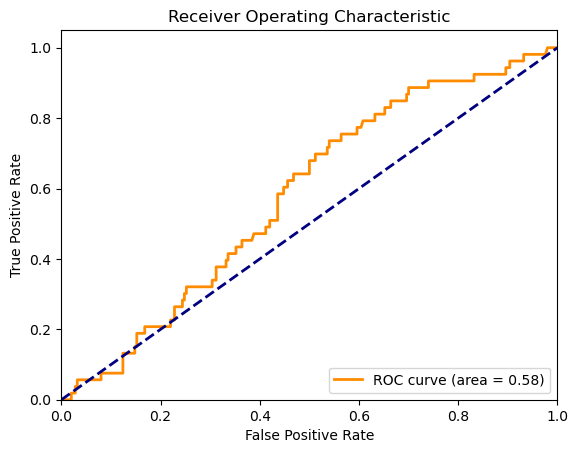

In [27]:
# 计算并打印AUC  
fpr, tpr, thresholds = roc_curve(y_test, y_prob)  
roc_auc = roc_auc_score(y_test, y_prob)  
print("AUC: {:.2f}%".format(roc_auc * 100))  
  
# 如果你想要绘制ROC曲线，可以使用matplotlib  
plt.figure()  
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)  
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  
plt.xlim([0.0, 1.0])  
plt.ylim([0.0, 1.05])  
plt.xlabel('False Positive Rate')  
plt.ylabel('True Positive Rate')  
plt.title('Receiver Operating Characteristic')  
plt.legend(loc="lower right")  
plt.show()

In [28]:
sum(y_test)

53

In [29]:
sum(y_pred)

7

In [25]:
# 奇偶比

def jioubi(df):
    jiou_list = []
    for i in range(df.shape[0]):
        ji = 0
        ou = 0
        for k in df.iloc[i].tolist()[2:-1]:
            if k%2 == 0:
                ji += 1
            else:
                ou += 1
        jiou_list.append(str(ji) + ':' + str(ou))
    return jiou_list


# 和值

def hezhi(df):
    hezhi_list = []
    for i in range(df.shape[0]):
        he = 0
        for k in df.iloc[i].tolist()[2:-1]:
            he += k
        hezhi_list.append(he)
    return hezhi_list


hezhi(data_o)

[100,
 99,
 101,
 65,
 103,
 88,
 99,
 76,
 104,
 65,
 94,
 104,
 114,
 75,
 117,
 150,
 110,
 113,
 86,
 127,
 128,
 78,
 110,
 93,
 71,
 122,
 98,
 115,
 111,
 85,
 130,
 126,
 99,
 99,
 41,
 132,
 116,
 96,
 114,
 64,
 89,
 60,
 91,
 97,
 88,
 79,
 139,
 131,
 78,
 100,
 100,
 110,
 132,
 101,
 115,
 129,
 147,
 129,
 64,
 78,
 109,
 90,
 90,
 75,
 117,
 94,
 99,
 145,
 107,
 61,
 94,
 74,
 102,
 114,
 138,
 97,
 103,
 127,
 129,
 136,
 102,
 122,
 90,
 75,
 74,
 107,
 66,
 113,
 144,
 48,
 123,
 90,
 128,
 84,
 109,
 106,
 105,
 82,
 67,
 99,
 129,
 138,
 84,
 72,
 109,
 102,
 79,
 105,
 93,
 95,
 96,
 89,
 115,
 111,
 106,
 75,
 43,
 120,
 91,
 93,
 72,
 61,
 99,
 125,
 106,
 81,
 126,
 124,
 113,
 111,
 85,
 90,
 90,
 112,
 115,
 85,
 90,
 107,
 107,
 68,
 88,
 67,
 105,
 119,
 126,
 134,
 90,
 90,
 98,
 124,
 122,
 101,
 125,
 148,
 110,
 75,
 89,
 99,
 128,
 94,
 132,
 89,
 100,
 127,
 94,
 83,
 90,
 100,
 104,
 112,
 133,
 148,
 70,
 113,
 112,
 70,
 109,
 134,
 128,
 120,
 85

In [17]:
data_o.shape

(2880, 9)

### 判断奇偶

In [13]:
# 做特征： 
#历史奇数百分比  历史偶数百分比  近一年奇数百分比  近一年偶数百分比  近半年奇数百分比  近半年偶数百分比  近三个月奇数百分比  近三个月偶数百分比  近一个月奇数百分比  近一个月偶数百分比
#近100次奇数百分比  近100次偶数百分比   近50次奇数百分比  近50次偶数百分比  近30次奇数百分比  近30次偶数百分比  近10次奇数百分比 近10次偶数百分比

data_o = pd.read_table('num.txt', sep = ',', header = None, names = ['date', 'phase', 'red1', 'red2', 'red3', 'red4', 'red5', 'red6', 'blue'], parse_dates = ['date'])
data_o.head()

,date,phase,red1,red2,red3,red4,red5,red6,blue
0,2003-02-23,2003001,10,11,12,13,26,28,11
1,2003-02-27,2003002,4,9,19,20,21,26,12
2,2003-03-02,2003003,1,7,10,23,28,32,16
3,2003-03-06,2003004,4,6,7,10,13,25,3
4,2003-03-09,2003005,4,6,15,17,30,31,16


In [14]:
data_o.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880 entries, 0 to 2879
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2880 non-null   datetime64[ns]
 1   phase   2880 non-null   int64         
 2   red1    2880 non-null   int64         
 3   red2    2880 non-null   int64         
 4   red3    2880 non-null   int64         
 5   red4    2880 non-null   int64         
 6   red5    2880 non-null   int64         
 7   red6    2880 non-null   int64         
 8   blue    2880 non-null   int64         
dtypes: datetime64[ns](1), int64(8)
memory usage: 202.6 KB


In [15]:
# 彩票从03年2月23号开始，2880期。大概每年153期，隔三天一期和隔四天一期。特征取成近三年的话就2495个样本


1285-1133+1

153

In [16]:
2880-386+1

2495